## Question

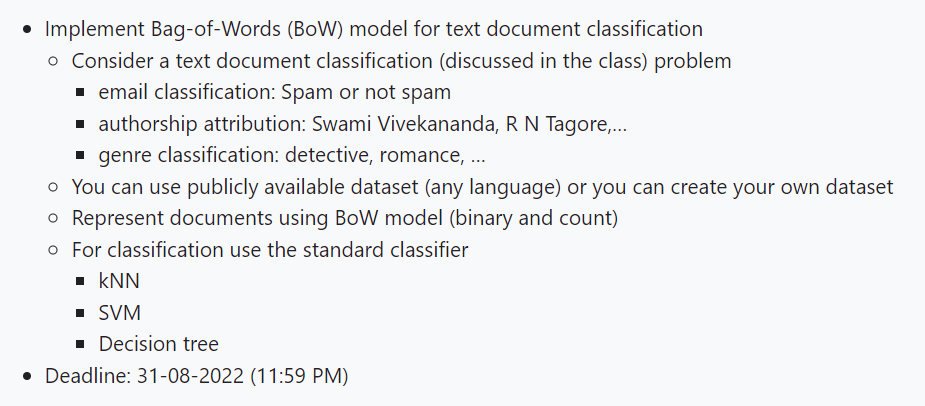

## Solution

### Import Libraries

In [1]:
import copy, time, sys, os
from tqdm.notebook import tqdm
# Import the basic datascience module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# For regular expression and NLP
import re
import nltk
# Import modules for classifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
# Import mesure metrices
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

### Reading data and EDA

Data Source: [https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset]()

In [2]:
# Read the data
data = pd.read_csv('./spam.csv', encoding="ISO-8859-1", header = 0)
data = data.iloc[:,0:2]
data.columns = ['target', 'text']
data.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
# Shape of the data
print("\33[35m The shape of the data is {}".format(data.shape))

 The shape of the data is (5572, 2)


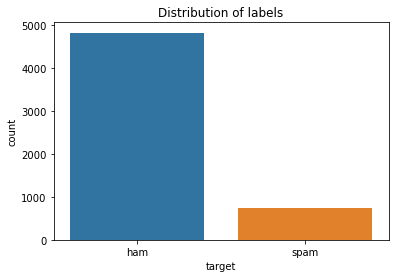

In [4]:
sns.countplot(x = 'target', data = data)
plt.title('Distribution of labels');

In [5]:
# Print the percentages of classes
data['target'].value_counts(normalize=True)*100

ham     86.593683
spam    13.406317
Name: target, dtype: float64

In [6]:
# Lets take first 100 rows and inspect it
# data = data.loc[0:500, ['topic','text']]
# data.head()

In [7]:
# Import the stopwords from nltk package
stop_words = nltk.corpus.stopwords.words('english')

In [8]:
# Define tokeniser function that is going to apply over text column
def tokeniser(sentence):
    # sentence is nothing but a string
    # Step 1: Make everything in lower case
    sentence = sentence.lower()
    # Step 2: Only grab the words using re module (ignoring words)
    words = re.findall('[a-z]+', sentence)
    # Step 3: Remove stop words using nltk stop words list
    filtered_word = [word for word in words if word not in stop_words]
    return filtered_word
# Lets test the funtion for one sentence
print(tokeniser(data.text[0]))

['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']


In [9]:
# Lets apply the function over the text column and make a new column called filtered_word
data['filtered_word'] = data['text'].apply(tokeniser)

In [10]:
# Inspect the data
data.head()

,target,text,filtered_word
0,ham,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...","[nah, think, goes, usf, lives, around, though]"


In [11]:
# Create vocabulary
def make_vocabulary(data):
    vocabulary = []
    for i in data['filtered_word']:
        vocabulary.extend(i)
    vocabulary = list(set(vocabulary))
    vocabulary.sort()
    return vocabulary
vocabulary = make_vocabulary(data)
print("\33[35m Size of the vocabulary is {}".format(len(vocabulary)))

 Size of the vocabulary is 7564


<h3 style="background-color:#DAF7A6;padding:7px;text-align:center;"> Binary Case </h3>

In [12]:
# Term document matrix
voc_len = len(vocabulary)
# Define a funtion for encoding (Binary)
def hotEncoding(word_list):
    # Initialize the null vector
    encoded_list = np.zeros(voc_len)
    for i in range(voc_len):
        if vocabulary[i] in word_list:
            encoded_list[i] = 1
        else:
            encoded_list[i] = 0
    return pd.Series(encoded_list)
# Lets check the function
print("Length of vector {}".format(len(hotEncoding(data.filtered_word[0]))))
# print("Number of words {}".format(np.sum(hotEncoding(sub_data.filtered_word[0]), dtype = 'int32')))

Length of vector 7564


In [13]:
# Now time to apply the above function in the column
dummy_df = data['filtered_word'].apply(hotEncoding)
dummy_df.columns = vocabulary
print("\33[35m Shape: {}".format(dummy_df.shape))
dummy_df.head()

 Shape: (5572, 7564)


,aa,aah,aaniye,aaooooright,aathi,ab,abbey,abdomen,abeg,abel,...,zeros,zf,zhong,zindgi,zoe,zogtorius,zoom,zouk,zs,zyada
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
X = dummy_df.values
y = data.target

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True, stratify = y)
# X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size = 0.5, shuffle = True, stratify = y_test)

In [16]:
pd.DataFrame({'Train':{'X':X_train.shape, 'y':y_train.shape}, 'Test':{'X':X_test.shape, 'y':y_test.shape}})
# pd.DataFrame({'Train':{'X':X_train.shape, 'y':y_train.shape}, 'Valid':{'X':X_valid.shape, 'y':y_valid.shape}, 'Test':{'X':X_test.shape, 'y':y_test.shape}})

,Train,Test
X,"(3900, 7564)","(1672, 7564)"
y,"(3900,)","(1672,)"


<h4 style="background-color:#33FFBD;padding:5px;font-size:12pt;text-align:center;"> k-Nearest Classifier </h4>

In [17]:
knn_result_dict = {}
for k in tqdm(range(1,11), desc = 'Traning'):
    knn = KNeighborsClassifier(k)
    knn.fit(X_train, y_train)
    knn_result_dict[str(k)] = knn.score(X_test, y_test)

Traning:   0%|          | 0/10 [00:00<?, ?it/s]

 Best achived accuracy is 0.96, for the 1 number of neighbours.


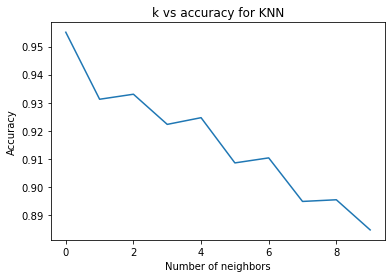

In [18]:
knn_result_df = pd.DataFrame(knn_result_dict.items(), columns=['k','accuracy'])
best_result_knn_b = knn_result_df.sort_values(['accuracy'], ascending = False).iloc[0,:]
# knn_result_dict
# sns.barplot(x = 'k', y = 'accuracy', data = knn_result_df)
print('\33[35m Best achived accuracy is {}, for the {} number of neighbours.'.format(np.round(best_result_knn_b[1],2), best_result_knn_b[0]))
plt.plot(knn_result_df.accuracy)
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.title('k vs accuracy for KNN');

<h4 style="background-color:#33FFBD;padding:5px;font-size:12pt;text-align:center;"> Support Vector Classifier </h4>

In [19]:
svm = SVC(kernel = 'linear')
svm.fit(X_train, y_train)
best_result_svc_b = svm.score(X_test, y_test)
print("\33[35m Test score {}".format(np.round(best_result_svc_b, 2)))

 Test score 0.98


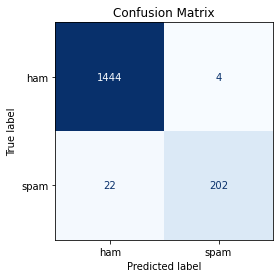

In [20]:
plot_confusion_matrix(svm, X_test, y_test, cmap=plt.cm.Blues, colorbar = False)
plt.title('Confusion Matrix');

<h4 style="background-color:#33FFBD;padding:5px;font-size:12pt;text-align:center;"> Decision Tree Classifier </h4>

In [21]:
dt_result_dict = {}
for d in tqdm(range(1,11), desc = 'Traning'):
    clf_DT = DecisionTreeClassifier(max_depth = d)
    clf_DT.fit(X_train, y_train)
    dt_result_dict[str(d)] = clf_DT.score(X_test, y_test)

Traning:   0%|          | 0/10 [00:00<?, ?it/s]

 Best achived accuracy is 0.96, for the depth 10.


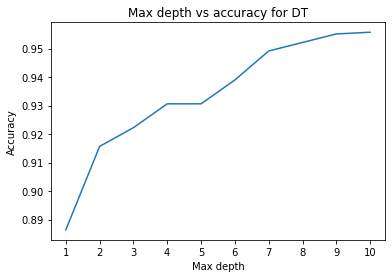

In [22]:
dt_result_df = pd.DataFrame(dt_result_dict.items(), columns=['max_depth','accuracy'])
best_result_dt_b = dt_result_df.sort_values(['accuracy'], ascending = False).iloc[0,:]
# sns.barplot(x = 'max_depth', y = 'accuracy', data = dt_result_df)
print('\33[35m Best achived accuracy is {}, for the depth {}.'.format(np.round(best_result_dt_b[1],2), best_result_dt_b[0]))
plt.plot(dt_result_df['max_depth'], dt_result_df['accuracy'])
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.title('Max depth vs accuracy for DT');

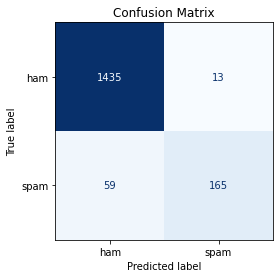

In [23]:
clf_DT = DecisionTreeClassifier(max_depth = 10)
clf_DT.fit(X_train, y_train)
plot_confusion_matrix(clf_DT, X_test, y_test, cmap=plt.cm.Blues, colorbar = False)
plt.title('Confusion Matrix');

<h3 style="background-color:#DAF7A6;padding:7px;text-align:center;">Frequency Case <h3>

In [24]:
# Term document matrix
voc_len = len(vocabulary)
# Define a funtion for encoding (Frequency)
def countEncoding(word_list):
    # Initialize the null vector
    encoded_list = np.zeros(voc_len)
    for i in range(voc_len):
        word = vocabulary[i]
        if word in word_list:
            encoded_list[i] = word_list.count(word)
        else:
            encoded_list[i] = 0
    return pd.Series(encoded_list)
# Lets check the function
# print("Length of vector {}".format(len(hotEncoding(sub_data.filtered_word[0]))))
# print("Number of words {}".format(np.sum(hotEncoding(sub_data.filtered_word[0]), dtype = 'int32')))

In [25]:
# Now time to apply the above function in the column
dummy_df_freq = data['filtered_word'].apply(countEncoding)
dummy_df_freq.columns = vocabulary
print("\33[35m Shape: {}".format(dummy_df_freq.shape))
dummy_df_freq.head()

 Shape: (5572, 7564)


,aa,aah,aaniye,aaooooright,aathi,ab,abbey,abdomen,abeg,abel,...,zeros,zf,zhong,zindgi,zoe,zogtorius,zoom,zouk,zs,zyada
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
X = dummy_df_freq.values
y = data.target

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True, stratify = y)
# X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size = 0.5, shuffle = True, stratify = y_test)

In [28]:
pd.DataFrame({'Train':{'X':X_train.shape, 'y':y_train.shape}, 'Test':{'X':X_test.shape, 'y':y_test.shape}})

,Train,Test
X,"(3900, 7564)","(1672, 7564)"
y,"(3900,)","(1672,)"


<h4 style="background-color:#33FFBD;padding:5px;font-size:12pt;text-align:center;"> k-Nearest Classifier </h4>

In [29]:
knn_result_dict = {}
for k in tqdm(range(1,11), desc = 'Traning'):
    knn = KNeighborsClassifier(k)
    knn.fit(X_train, y_train)
    knn_result_dict[str(k)] = knn.score(X_test, y_test)

Traning:   0%|          | 0/10 [00:00<?, ?it/s]

 Best achived accuracy is 0.95, for the 1 number of neighbours.


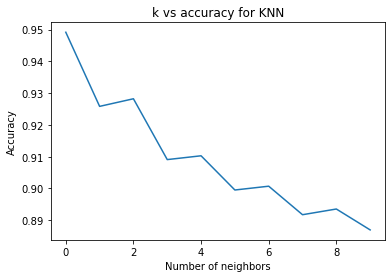

In [30]:
knn_result_df = pd.DataFrame(knn_result_dict.items(), columns=['k','accuracy'])
best_result_knn_f = knn_result_df.sort_values(['accuracy'], ascending = False).iloc[0,:]
# knn_result_dict
# sns.barplot(x = 'k', y = 'accuracy', data = knn_result_df)
print('\33[35m Best achived accuracy is {}, for the {} number of neighbours.'.format(np.round(best_result_knn_f[1],2), best_result_knn_f[0]))
plt.plot(knn_result_df.accuracy)
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.title('k vs accuracy for KNN');

<h4 style="background-color:#33FFBD;padding:5px;font-size:12pt;text-align:center;"> Support Vector Classifier </h4>

In [31]:
svm = SVC(kernel = 'linear')
svm.fit(X_train, y_train)
best_result_svc_f = svm.score(X_test, y_test)
print("\33[35m Test score {}".format(np.round(best_result_svc_f, 2)))

 Test score 0.98


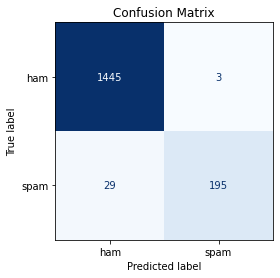

In [32]:
plot_confusion_matrix(svm, X_test, y_test, cmap=plt.cm.Blues, colorbar = False)
plt.title('Confusion Matrix');

<h4 style="background-color:#33FFBD;padding:5px;font-size:12pt;text-align:center;"> Decision Tree Classifier </h4>

In [33]:
dt_result_dict = {}
for d in tqdm(range(1,11), desc = 'Traning'):
    clf_DT = DecisionTreeClassifier(max_depth = d)
    clf_DT.fit(X_train, y_train)
    dt_result_dict[str(d)] = clf_DT.score(X_test, y_test)

Traning:   0%|          | 0/10 [00:00<?, ?it/s]

 Best achived accuracy is 0.96, for the depth 10.


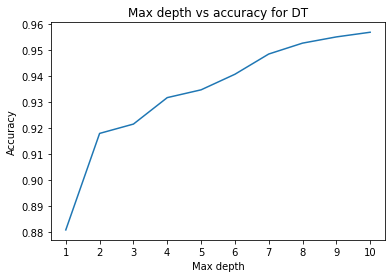

In [34]:
dt_result_df = pd.DataFrame(dt_result_dict.items(), columns=['max_depth','accuracy'])
best_result_dt_f = dt_result_df.sort_values(['accuracy'], ascending = False).iloc[0,:]
# sns.barplot(x = 'max_depth', y = 'accuracy', data = dt_result_df)
print('\33[35m Best achived accuracy is {}, for the depth {}.'.format(np.round(best_result_dt_f[1],2), best_result_dt_f[0]))
plt.plot(dt_result_df['max_depth'], dt_result_df['accuracy'])
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.title('Max depth vs accuracy for DT');

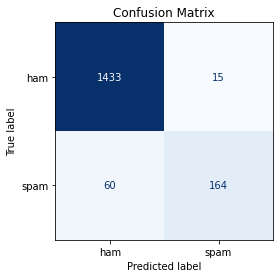

In [35]:
clf_DT = DecisionTreeClassifier(max_depth = 10)
clf_DT.fit(X_train, y_train)
plot_confusion_matrix(clf_DT, X_test, y_test, cmap=plt.cm.Blues, colorbar = False)
plt.title('Confusion Matrix');

In [36]:
output = pd.DataFrame({'Binary': [best_result_knn_b[1], best_result_svc_b, best_result_dt_b[1]],
                       'Frequency': [best_result_knn_f[1], best_result_svc_f, best_result_dt_f[1]]}, index = ['KNN','SVC','DT'], )
np.round(output*100, 2)

,Binary,Frequency
KNN,95.51,94.92
SVC,98.44,98.09
DT,95.57,95.69


In [37]:
pd.DataFrame({'Binary': [best_result_knn_b[0], 'linear', best_result_dt_b[0]],
              'Frequency': [best_result_knn_f[0], 'linear', best_result_dt_f[0]]}, index = ['KNN (k)','SVC (kernel)','DT (max depth)'], )

,Binary,Frequency
KNN (k),1,1
SVC (kernel),linear,linear
DT (max depth),10,10


<div class="alert alert-block alert-info">
<b>Conclusion:</b> Using Support Vector Classifier we get maximum accuracy (more than 98%) among three classifier KNN, SVC and DT.
</div>
